In [275]:
# Import Packages
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
import numpy as np
import warnings; warnings.simplefilter('ignore')

In [276]:
def parser(s):
    return datetime.strptime(s, "%Y-%m-%d")

In [277]:
# Load Data
data = pd.read_csv('/datc/parcel/notebooks/data/postnl/20201014_300_klanten.csv', parse_dates=[0])

In [278]:
cust_filter = data['cust_id'] == 'klant_69'
date_filter = data['procesdag'].dt.dayofweek <= 4
data = data.where(date_filter & cust_filter).dropna()
#data = data.where(cust_filter).dropna()

data['procesdag']=pd.to_datetime(data['procesdag'])
data = data.set_index(data.procesdag, drop=True)
data = data['2016-01-01':'2020-01-01']

In [279]:
data.drop(['procesdag'], axis='columns', inplace=True)
data.drop(['aantal_pakketten_volgende_dag'], axis='columns', inplace=True)

In [280]:
data.head()

,cust_id,aantal_pakketten,validation_column
procesdag,,,
2016-01-01,klant_69,0.0,train
2016-01-04,klant_69,330.0,train
2016-01-05,klant_69,301.0,train
2016-01-06,klant_69,391.0,train
2016-01-07,klant_69,301.0,train


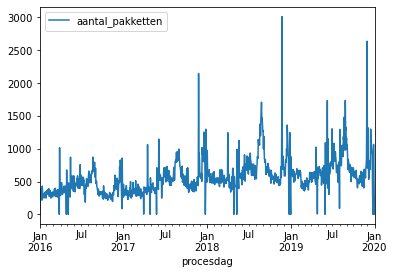

In [281]:
data.plot()

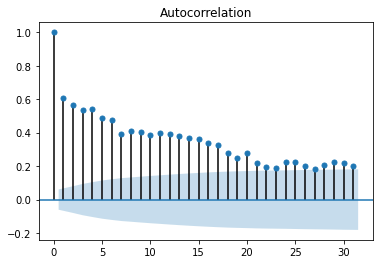

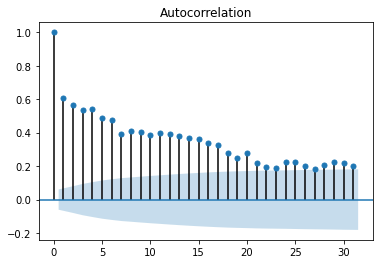

In [282]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['aantal_pakketten'])

In [283]:
data_diff = data['aantal_pakketten'].diff()
data_diff.fillna(0, inplace=True)
data_diff.head()

procesdag
2016-01-01      0.0
2016-01-04    330.0
2016-01-05    -29.0
2016-01-06     90.0
2016-01-07    -90.0
Name: aantal_pakketten, dtype: float64

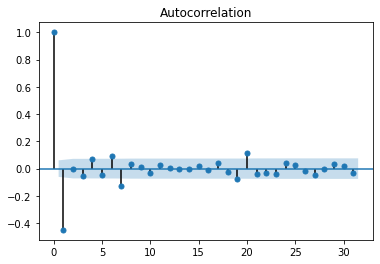

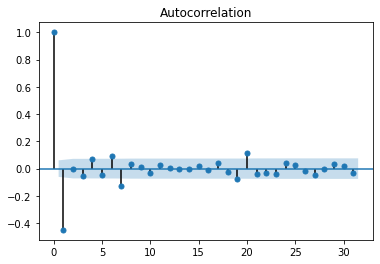

In [284]:
plot_acf(data_diff)

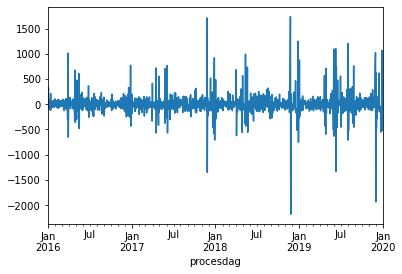

In [285]:
data_diff.plot()

# TRAIN AND TEST

In [286]:
y = data_diff
X = data.index
print(y.size)
train = y[:750] # 1000 training data
val = train[-250:] # 365 validatie data
test = y[-250:] # 365 testing data
predictions = []

1044


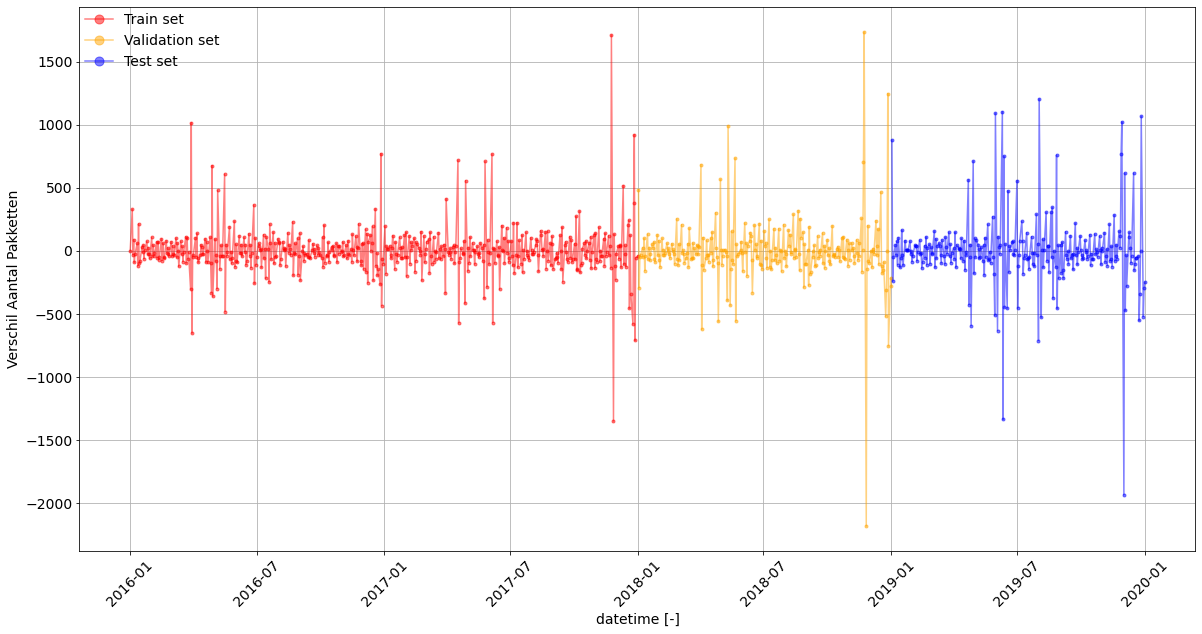

In [287]:
from sklearn.model_selection import train_test_split

y = data_diff
X = data.index

train_size = 0.75
val_size = 0.25

split_index_val = int(data.shape[0]*(train_size-val_size))
split_index_test = int(data.shape[0]*train_size)

X_train = X[:split_index_val]
X_val = X[split_index_val:split_index_test]
X_test = X[split_index_test:]

y_train = y[:split_index_val]
y_val = y[split_index_val:split_index_test]
y_test = y[split_index_test:]

X_train_values = data[:split_index_val] # get the datetime values of X_train
X_val_values = data[split_index_val:split_index_test]
X_test_values = data[split_index_test:]

plt.figure(figsize=(20,10))

plt.plot(X_train_values.index, y_train, '.-', color='red', label='Train set', alpha=0.5)
plt.plot(X_val_values.index, y_val, '.-', color='orange', label='Validation set', alpha=0.5)
plt.plot(X_test_values.index, y_test, '.-', color='blue', label='Test set', alpha=0.5)

plt.ylabel(r'Verschil Aantal Pakketten', fontsize=14)
plt.xlabel('datetime [-]', fontsize=14)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)
plt.grid()

Root Mean Squared Error: 152.28294603654243


<Figure size 1440x576 with 0 Axes>

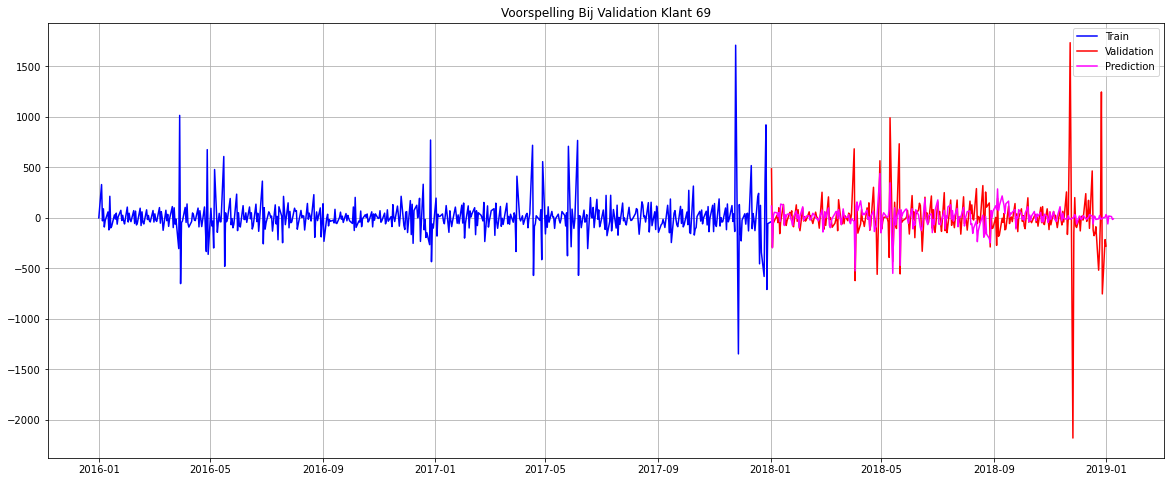

In [288]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score

# Fit ARIMA Model
my_order = (1,0,1)
my_seasonal_order = (0, 1, 1, 12)
fig = plt.figure(figsize=(20,8))
model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)
results = model.fit()
predictions = results.predict(start=(522), end=(788), dynamic=False)

# plot van train data
plt.figure(figsize=(20,8))
plt.plot(X_train, y_train, color='blue', alpha=1) # train
plt.plot(X_val, y_val, color='red', alpha=1)
plt.plot(predictions, color='magenta', alpha=1)
#plt.plot(X_test, y_test, color='magenta', alpha=1)
plt.grid()
plt.title('Voorspelling Bij Validation Klant 69')
plt.legend(['Train', 'Validation', 'Prediction'])
residuals = train - results.fittedvalues
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 150.99771991853717


<Figure size 1440x576 with 0 Axes>

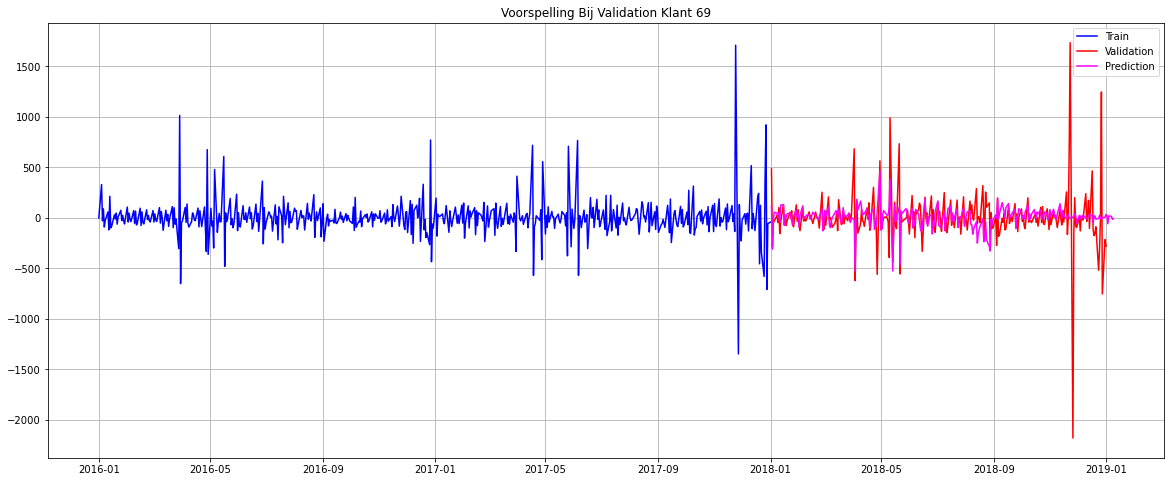

In [289]:
my_order = (3,0,2)
my_seasonal_order = (0, 1, 2, 12)
fig = plt.figure(figsize=(20,8))
model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)
results = model.fit()
predictions = results.predict(start=(522), end=(788), dynamic=False)

# plot van train data
plt.figure(figsize=(20,8))
plt.plot(X_train, y_train, color='blue', alpha=1) # train
plt.plot(X_val, y_val, color='red', alpha=1)
plt.plot(predictions, color='magenta', alpha=1)
#plt.plot(X_test, y_test, color='magenta', alpha=1)
plt.grid()
plt.title('Voorspelling Bij Validation Klant 69')
plt.legend(['Train', 'Validation', 'Prediction'])
residuals = train - results.fittedvalues
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

In [290]:
print(y)

procesdag
2016-01-01       0.0
2016-01-04     330.0
2016-01-05     -29.0
2016-01-06      90.0
2016-01-07     -90.0
               ...  
2019-12-26       0.0
2019-12-27    1066.0
2019-12-30    -520.0
2019-12-31    -297.0
2020-01-01    -249.0
Name: aantal_pakketten, Length: 1044, dtype: float64


Root Mean Squared Error: 150.99771991853717


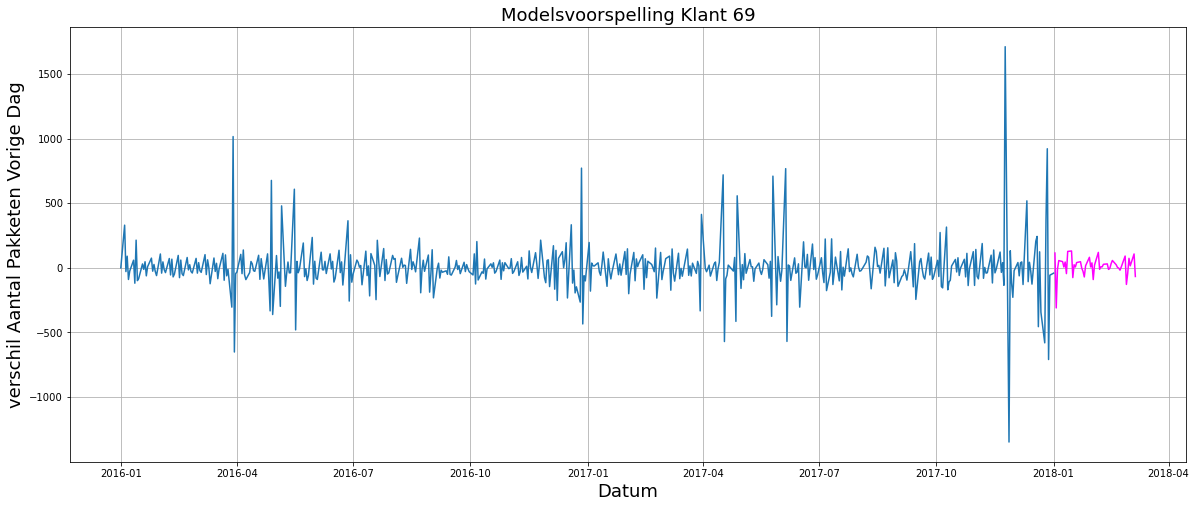

In [291]:
# Model only with Oktober
fig = plt.figure(figsize=(20,8))
num_points = len(data_diff)
x = results.predict(start=(522), end=(567), dynamic=False)

plt.plot(X_train, y_train)
plt.plot(x, color='magenta')
plt.xlabel('Datum',fontsize= 18)
plt.ylabel('verschil Aantal Pakketen Vorige Dag',fontsize= 18)
plt.title('Modelsvoorspelling Klant 69',fontsize= 18)
plt.grid()
residuals = data_diff - results.fittedvalues
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

43


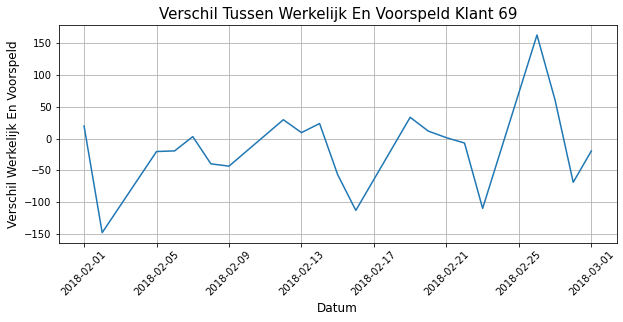

In [292]:
# Model with Difference
print(x['2018-01-01':'2018-03-01'].size)
diff = data_diff['2018-02-01':'2018-03-01'] - x['2018-02-01':'2018-03-01']
plt.figure(figsize=(10,4))
plt.plot(diff)
plt.xlabel('Datum', fontsize=12)
plt.ylabel('Verschil Werkelijk En Voorspeld', fontsize=12)
plt.title('Verschil Tussen Werkelijk En Voorspeld Klant 69', fontsize=15)
plt.xticks(rotation=45)
plt.grid()

Root Mean Squared Error: 150.99771991853717
0.33790341064655194


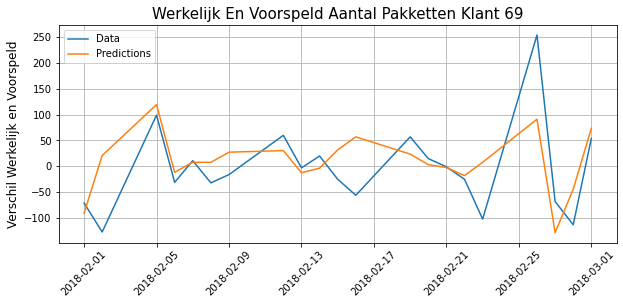

In [299]:
plt.figure(figsize=(10,4))
plt.plot(data_diff['2018-02-01':'2018-03-01'])
plt.plot(x['2018-02-01':'2018-03-01'])
plt.ylabel('Verschil Werkelijk en Voorspeld', fontsize=12)
plt.title('Werkelijk En Voorspeld Aantal Pakketten Klant 69', fontsize=15)
plt.legend(['Data', 'Predictions'])
plt.xticks(rotation=45)
plt.grid()
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))
from sklearn.metrics import r2_score
print(r2_score(data_diff['2018-02-01':'2018-03-01'], x['2018-02-01':'2018-03-01']))